THE FIREFIGTER PROBLEM


In [1]:
def skrcitev(dic, t):
    ''' pomožna funkcija skrcitev vrne seznam, ki vsebuje vozlišča, ki jih je potrebno pobarvati (imajo vrednost ključa 1) v določenem času '''

    new = []
    for key in dic:
        if key[1] == t and dic[key] == 1:
            new.append(key[0])
    return new



def clp(G, B, gasilci):
    ''' vhodni podatki:
         G           izbran graf
         B           vozlišča, ki na začetku zgorijo
         gasilci     število gasilcev, ki v vsakem koraku gasijo požar
     izhodni podatki:
         seznam oblike [število časovnih enot, pogorela/burnt vozlišča po časih, zaščitena/defended vozlišča po časih] '''
    cas = 10
    while True:
        casi = range(1, cas+1) # uprabljamo pri zankah
    
        # CLP:
        p = MixedIntegerLinearProgram(maximization=False) # CLP
        d = p.new_variable(binary=True) # spremenljivka, defended
        b = p.new_variable(binary=True) # spremenljivka, burnt

        p.set_objective(sum(b[i, cas] for i in G)) # minimiziramo število pogorelih vozlišč na koncu 

        for t in casi:
            for i in G:
                for j in G[i]: # j je številka v seznamu vozlišča i, sosed od i
                    p.add_constraint(b[i,t] + d[i,t] - b[j,t-1] >= 0)
                p.add_constraint(b[i,t] + d[i,t] <= 1)
                p.add_constraint(b[i,t] - b[i,t-1] >= 0)
                p.add_constraint(d[i,t] - d[i,t-1] >= 0)
            p.add_constraint(sum((d[i,t] - d[i,t-1]) for i in G) <= gasilci)

        for i in G:
            p.add_constraint(b[i,0] == (1 if i in B else 0))
            p.add_constraint(d[i,0] == 0)
            
        k = p.solve()
        l = p.get_values(b)
        m = p.get_values(d)
        
        #Ali je problem končan?
        n = skrcitev(l, cas) # burnt vozlišča v cas
        e = skrcitev(m, cas) # defended vozlišča v cas
        skupaj = n + e
        
        koncan = 1
        # sosedi od pogorelih vozlišč so lahko pogoreli ali zaščiteni. Ne smejo biti prazna vozlišča
        for pogorelo_vozlisce in n:
            for sosed_od_pogorelo_vozlisce in G[pogorelo_vozlisce]:
                if sosed_od_pogorelo_vozlisce not in skupaj:
                    koncan = 0
        koncan
        
        if koncan == 1:
            break
        else:
            cas += 10
        
    return [k, l, m]



def ali_je_problem_koncan(G, B, gasilci, t):  
    ''' funkcija nam pove ali je problem v času t zaključen/končen '''
    
    b = skrcitev(clp(G, B, gasilci)[1], t) # burnt vozlišča v t
    d = skrcitev(clp(G, B, gasilci)[2], t) # defended vozlišča v t
    skupaj = b + d

    # sosedi od pogorelih vozlišč so lahko pogoreli ali zaščiteni. Ne smejo biti prazna vozlišča
    for pogorelo_vozlisce in b:
        for sosed_od_pogorelo_vozlisce in G[pogorelo_vozlisce]:
            if sosed_od_pogorelo_vozlisce not in skupaj:
                return False
    return True

   
def cas_potreben(G, B, gasilci):
    ''' iz p.solve() pridobi čas po katerem se nič več ne spremeni -> dobimo potreben čas '''
    #cas = 10 #začetni cas
    cas = 10
    while True:
        t, burnt, defended = clp(G, B, gasilci)

        urej_burnt = sorted(burnt.items(), key=lambda tup: tup[0][1]) #uredi glede na čas po vozliščih naraščajoče
        urej_defended = sorted(defended.items(), key=lambda tup: tup[0][1]) 

        vredn_burnt= []
        for i, v in urej_burnt:
            vredn_burnt.append(v)
        # pridobim ven vrednosti spremnljivk b v časih in vozliščih naraščajoče

        vredn_defended= []
        for i, v in urej_defended:
            vredn_defended.append(v)
        # pridobim ven vrednosti spremnljivk d v časih in vozliščih naraščajoče

        # from itertools import islice
        from itertools import accumulate
        dolzina = [len(G)] * (cas +1) # Vrednosti zgrupiram v paketke, v vsakem je toliko vrednosti, kolikor je vozlišč
        seznami_vrednosti_po_casih_burnt = [tuple(vredn_burnt[x - y: x]) for x, y in zip(
                            accumulate(dolzina), dolzina)]

        seznami_vrednosti_po_casih_defended = [tuple(vredn_defended[x - y: x]) for x, y in zip(
                            accumulate(dolzina), dolzina)]

        d = next(i for i in range(len(dolzina)) if all(len(set(l[i:i+2])) == 1 for l in (seznami_vrednosti_po_casih_burnt, seznami_vrednosti_po_casih_defended)))
        if d < cas:
            break
        else:
            cas += 10
    return d



def barvanje_v_casu_t(G, B, gasilci, t):
    ''' pomožna funkcija barvanje_v_casu_t izriše graf in pobarva vozlišča v določenem času (t). Začetna vozlišča oz. izvor pošara pobarva v zeleno, 
         pogorela v  rdečo, zaščitena pa v modro. '''

    b = skrcitev(clp(G, B, gasilci)[1], t) # burnt vozlišča v času t BREZ ZAČETNIH VOZLIŠČ B
    for el in B:
        b.remove(el)
    d = skrcitev(clp(G, B, gasilci)[2], t) # defended vozlišča v času t
    
    return G.show(partition = [b, B, d])


def barvanje_po_korakih(G, B, gasilci):
    ''' funkcija, ki za vsako časovno enoto nariše situacijo na grafu
         barve:
             - zelena: oglišča kjer se požar začne (B)
             - rdeča: pogorela
             - modra: zaščitena '''
    
    time = cas_potreben(G, B, gasilci)
    print("Število potrebnih časovnih korakov: " + str(time))
    for t in range(0, time + 1):
        print("Situacija v času " + str(t) + ":")
        barvanje_v_casu_t(G, B, gasilci, t)

Število potrebnih časovnih korakov: 2
Situacija v času 0:


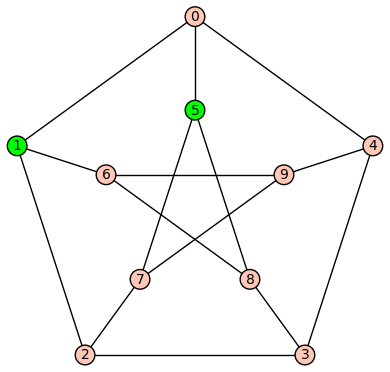

Situacija v času 1:


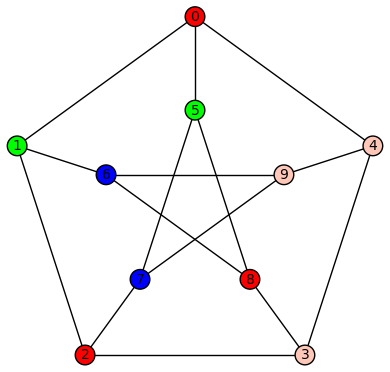

Situacija v času 2:


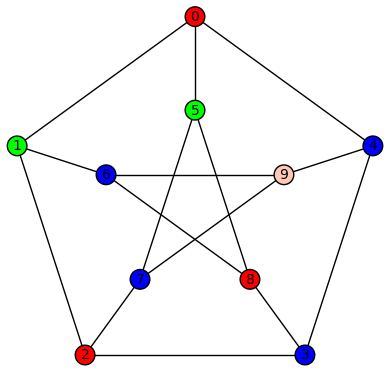

In [2]:
# PRIMER:
G = graphs.PetersenGraph()
B = [1,5]
gasilci = 2
barvanje_po_korakih(G, B, gasilci)

In [3]:
import random
def nakljucno_izberi_vzolisca(graf, n):
    ''' funkcija naključno izbere n vozlišč iz grafa graf '''
    return random.sample(list(graf), n)

def seznam_naborov_st_vozlisc_cas(seznam_imen_grafov, st_gasilcev, stevilo_vozlisc_v_B):
    ''' funkcija, ki sprejme seznam v katerem so imena grafov, število gasilcev ter število vozlišč, ki jih želimo v začetni množici B.
            Vrne pa seznam naborov oblike (število vozlišč, potreben čas reševanje problema)'''
    
    # sprehodimo se po seznam_imen_grafov in sestavljamo nabor:
    seznam_naborov = []
    for graf in seznam_imen_grafov:
        B1 = nakljucno_izberi_vzolisca(graf, stevilo_vozlisc_v_B)
        B2 = nakljucno_izberi_vzolisca(graf, stevilo_vozlisc_v_B)
        potreben_cas1 = cas_potreben(graf, B1, st_gasilcev)
        potreben_cas2 = cas_potreben(graf, B2, st_gasilcev)
        seznam_naborov.append((len(graf), potreben_cas1))
        seznam_naborov.append((len(graf), potreben_cas2))
    
    return seznam_naborov

In [4]:
# sestavljanje seznama grafov:

#c = graphs.CycleGraph(5)
#p = graphs.PathGraph(3)

#seznam_grafov = [graphs.HeawoodGraph(), p.cartesian_product(c), graphs.PappusGraph()]

#for i in range(3, 100): # manj kot 3 je nesmiselno
#    seznam_grafov.append(graphs.CircularLadderGraph(i)) # ima 2 * i vozlišč

#for i in range(2, 15):
#    for j in range(3,15):
#        seznam_grafov.append(graphs.Grid2dGraph(i,j)) # matrika i x j, tj. ima i * j vozlišč

#for i in range(4, 15):
#    for j in range(4,15):
#        seznam_grafov.append(graphs.CycleGraph(i).cartesian_product(graphs.CycleGraph(j))) # ima i * j vozlišč

#for i in range(3, 15):
#    for j in range(3, 15):
#        seznam_grafov.append(graphs.RandomBlockGraph(i, j))
        
# zmanjka prostora v programu ...

# s tem dobimo zelo velik seznam grafov, na katerem lahko izvedemo funkcijo seznam_naborov_st_vozlisc_cas za poljubno število vozlišč in vozlišč v B:
#seznam_naborov_1_2 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 1, 2)
#seznam_naborov_1_3 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 1, 3)
#seznam_naborov_1_4 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 1, 4)

#seznam_naborov_2_2 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 2, 2)
#seznam_naborov_2_3 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 2, 3)
#seznam_naborov_2_4 = seznam_naborov_st_vozlisc_cas(seznam_grafov, 2, 4)


# V naslednjem koraku zaženemo kodo in dobimo zelo velik seznam, ki ga v ločeni .py datoteki pretvorimo v .csv obliko s katero bomo
#         lahko izrisali grafe (število potrebnih časovnih enot v odvisnosti od števila vozlišč grafa).

KeyboardInterrupt: 

In [12]:
#Grafi za testiranje časovne zahtevnosti
from sage.graphs.graph_generators_pyx import RandomGNP
h = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] #tukaj so števila vozlišč
D = []
set_random_seed(0)
for i in h: 
       D.append(RandomGNP(i, 0.4, directed=False)) # generira graf z i vozlišči, 0.4 je verjetnost za povezavo
        
# za risanje:
D1 = D[0]
D2 = D[1]
D3 = D[2]
D4 = D[3]
D5 = D[4]
D6 = D[5]
D7 = D[6]
D8 = D[7]
D9 = D[8]
D10 = D[9]

# risanje grafov: D[1].plot()


In [22]:
# vzamemo povprečje časov:
import timeit
def casovna_zahtevnost(clp):
    ''' funkcija izračuna časovno zahtevnost funkcije clp na izbranem grafu, izvor požara je naključek (1 vozlišče), gasi en gasilec.
        Funkcija je generirana tako, da se 'ponovi' 5x in vrne povprečje '''

    def addition():
        return ('Addition:', clp)

    # run same code 5 times to get measurable data
    n = 5

    # calculate total execution time
    result = timeit.timeit(stmt='addition()', globals=globals(), number=n)
    # average:
    return result / n

def casovna_zahtevnost_na_seznamu_grafov(sez_grafov):
    ''' funkcija vrne seznam naborov oblike (število vozlišč, število potrebnih časovnih korakov, časovna zahtevnost) '''
    sez = []
    for i in range(len(sez_grafov)):
        graf = sez_grafov[i]
        B = nakljucno_izberi_vzolisca(graf, 1)
        gasilci = 1
        sez.append((len(graf), cas_potreben(graf, B, gasilci), casovna_zahtevnost(clp(graf, B, gasilci))))
    return sez
        
casovna_zahtevnost_na_seznamu_grafov(D)

[(5, 1, 0.13724519059978774),
 (10, 4, 0.0993092381999304),
 (15, 2, 0.10768598499998916),
 (20, 3, 0.198739523999393),
 (25, 2, 0.09992186119998223),
 (30, 2, 0.18543591780035057),
 (35, 3, 0.09710135900022579),
 (40, 3, 0.09878719039988937),
 (45, 2, 0.11259441459988011),
 (50, 2, 0.0984892642001796)]